In [1]:
#Nessesary libs
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications import EfficientNetV2B0

target_shape = (200, 200)

2023-09-16 14:15:55.015577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 14:15:55.739545: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-16 14:15:55.739595: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-09-16 14:15:55.739599: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
cache_dir = Path(Path.home()) / ".keras"
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"
cache_dir

PosixPath('/home/bartlomiej/.keras')

In [3]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
!gdown 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

Downloading...
From (uriginal): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
From (redirected): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34&confirm=t&uuid=8cd54a20-b536-4110-b242-0051ac31902b
To: /home/bartlomiej/PycharmProjects/pythonProject/left.zip
100%|████████████████████████████████████████| 104M/104M [00:04<00:00, 25.8MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
From (redirected): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW&confirm=t&uuid=f832f7fa-78fa-4369-8c38-026aebf669a1
To: /home/bartlomiej/PycharmProjects/pythonProject/right.zip
100%|████████████████████████████████████████| 104M/104M [00:02<00:00, 45.1MB/s]


In [4]:
def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_pair(pair, label):
    return ((
        preprocess_image(pair[0]),
        preprocess_image(pair[1]),
    ),label)

In [5]:
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_images)


anchors = anchor_images * 3
negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)
labels  = tf.constant([0.0]*6016 + [1.0]*12032) #reversed as opposed to the other netowrk, 0 means 0 distance, 1 means pictures are far away

comps = positive_images + negative_images

#input_imgs = tf.stack([img_1, img_2], axis=0)
dataset = tf.data.Dataset.from_tensor_slices(((anchors, comps), labels))
dataset = dataset.shuffle(buffer_size=20000)
dataset = dataset.map(preprocess_pair)
image_count*=3
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(8, drop_remainder=False)
# train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(8, drop_remainder=False)
# val_dataset = val_dataset.prefetch(8)

2023-09-16 14:16:26.475738: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-16 14:16:26.489503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-16 14:16:26.489615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-16 14:16:26.490465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
ex = next(dataset.batch(60).as_numpy_iterator())

[0. 0. 0. 1. 1.]


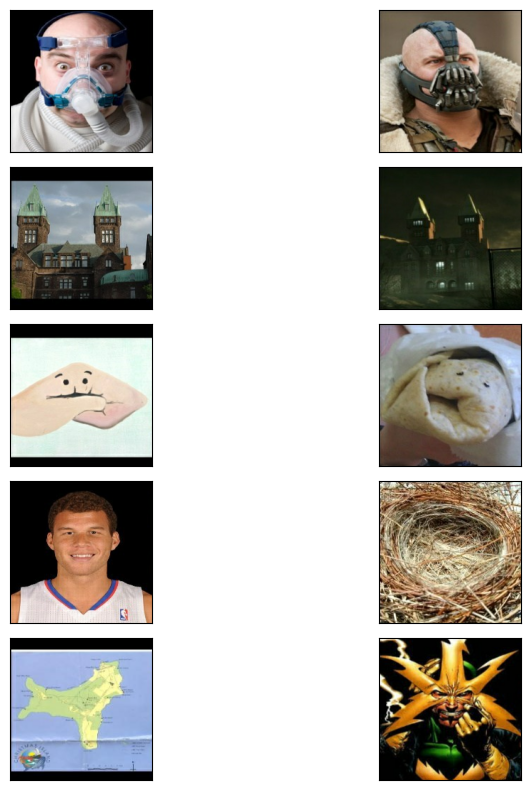

In [29]:
ex0 = ex[0][0]
ex1 = ex[0][1]

print(ex[1][:5])
fig, axes = plt.subplots(5, 2, figsize=(10, 8))
# Iterate through subplots and display images
for i, ax in enumerate(axes):
    ax[0].imshow(ex0[i])
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[1].imshow(ex1[i])
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)
plt.tight_layout()
# plt.show()

In [30]:
from keras.layers import Dense, Concatenate, Reshape, Input, Conv2D, ReLU, BatchNormalization, GlobalAveragePooling2D
from keras.applications import EfficientNetV2B3
from keras.utils import plot_model

# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

transfer_layer_size = 1000
base_cnn = EfficientNetV2B3(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)
# for layer in base_cnn.layers:
#     layer.trainable = False
flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(1024, activation="relu")(flatten)
# dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(750, activation="relu")(dense1)
dense3 = layers.Dense(900, activation="relu")(dense2)
output = layers.Dense(transfer_layer_size, activation='relu')(dense3)


embedding = Model(inputs = base_cnn.input, outputs = output, name="Embedding")


input_1 = Input(target_shape + (3,), name="input_image_1")
input_2 = Input(target_shape + (3,), name="input_image_2")

tower_1 = embedding(input_1)
tower_2 = embedding(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
# normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
# output_layer = layers.Dense(1, activation="relu")(merge_layer)
model = Model(inputs=[input_1, input_2], outputs=merge_layer)


In [7]:
def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


In [32]:
# model.compile(loss=loss(1), optimizer='RMSprop', metrics=['accuracy']) # 0.001 -> 0.001 binary_crossentropy ->mean_absolute_error
model.compile(loss=loss(1.0), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy']) 
from keras.callbacks import EarlyStopping
es = EarlyStopping(patience=3)

In [33]:
history = model.fit(train_dataset, epochs=40, validation_data=val_dataset, callbacks=[es])

Epoch 1/40


2023-09-14 18:49:46.108526: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/Embedding/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1805/1805 [==============================] - 424s 216ms/step - loss: 0.2996 - accuracy: 0.6657 - val_loss: 0.2044 - val_accuracy: 0.6981
Epoch 2/40
1805/1805 [==============================] - 401s 222ms/step - loss: 0.2071 - accuracy: 0.6908 - val_loss: 0.1901 - val_accuracy: 0.7319
Epoch 3/40
1805/1805 [==============================] - 408s 226ms/step - loss: 0.1900 - accuracy: 0.7209 - val_loss: 0.1687 - val_accuracy: 0.7582
Epoch 4/40
1805/1805 [==============================] - 407s 225ms/step - loss: 0.1736 - accuracy: 0.7501 - val_loss: 0.1424 - val_accuracy: 0.8080
Epoch 5/40
1805/1805 [==============================] - 405s 225ms/step - loss: 0.1595 - accuracy: 0.7734 - val_loss: 0.1280 - val_accuracy: 0.8432
Epoch 6/40
1805/1805 [==============================] - 402s 222ms/step - loss: 0.1438 - accuracy: 0.8031 - val_loss: 0.1204 - val_accuracy: 0.8518
Epoch 7/40
1805/1805 [==============================] - 399s 221ms/step - loss: 0.1288 - accuracy: 0.8301 - val_loss: 0.102

In [35]:
model.save('distance90pacc.keras')

2023-09-14 21:33:18.045527: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 308281344 exceeds 10% of free system memory.
2023-09-14 21:33:18.678451: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 308281344 exceeds 10% of free system memory.


In [10]:
import tensorflow as tf

model = tf.keras.models.load_model('./distance90pacc.keras',
                                   custom_objects={'contrastive_loss':                   loss(1)})

2023-09-16 14:20:02.616095: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 308281344 exceeds 10% of free system memory.
2023-09-16 14:20:04.356516: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 308281344 exceeds 10% of free system memory.


In [11]:
total = 0
true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0
positive = 0
negative = 0
for i in range(len(val_dataset)):
    data = next(val_dataset.batch(1).as_numpy_iterator())
    for k in range(8):
        img1 = np.array([data[0][0][0][k]])
        img2 = np.array([data[0][1][0][k]])
        sim = data[1][0][k]
        pred = model.predict([img1, img2])[0]
        if sim == 1.0:
            negative+=1
            if pred > 0.5:
                true_negative += 1
            else:
                false_positive +=1
        if sim == 0.0:
            positive+=1
            if pred > 0.5:
                false_negative += 1
            else:
                true_positive +=1

2023-09-16 14:23:38.894630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2023-09-16 14:23:39.165701: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 22ms/step


In [12]:
accuracy = (true_positive + true_negative)/(positive+negative)
precision = true_positive/(true_positive+false_positive)
recall = true_positive/(true_positive + false_negative)
f1 = 2 * (precision * recall)/(precision+recall)
print('accuracy', accuracy)
print('precision', precision)
print('recall', recall)
print('f1-score', f1)

accuracy 0.9546460176991151
precision 0.968722073279714
recall 0.8936521022258862
f1-score 0.9296740994854202


In [13]:
print('true_positive', true_positive)
print('false_positive', false_positive)
print('true_negative',true_negative)
print('false_negative',false_negative)
print('positive',positive)
print('negative',negative)

true_positive 1084
false_positive 35
true_negative 2368
false_negative 129
positive 1213
negative 2403


In [15]:
true_positive = 1040
true_negative = 2189
false_positive = 208
false_negative = 179
accuracy = (true_positive + true_negative)/(positive+negative)
precision = true_positive/(true_positive+false_positive)
recall = true_positive/(true_positive + false_negative)
f1 = 2 * (precision * recall)/(precision+recall)
print('accuracy', accuracy)
print('precision', precision)
print('recall', recall)
print('f1-score', f1)

accuracy 0.8929756637168141
precision 0.8333333333333334
recall 0.8531583264971287
f1-score 0.8431293068504256


In [11]:
import re

dense_train_loss = []
dense_train_acc =  []
dense_val_loss =   []
dense_val_acc =    []


distance_val_acc = []
distance_val_loss = []
distance_train_loss = []
distance_train_acc = []
# Przykładowy tekst z danymi o accuracy, loss, val_accuracy i val_loss
text = """
Epoch 1/40 1805/1805 [==============================] - 381s 192ms/step - loss: 0.2221 - accuracy: 0.6657 - mean_squared_error: 0.2221 - val_loss: 0.1989 - val_accuracy: 0.6856 - val_mean_squared_error: 0.1989
Epoch 2/40 1805/1805 [==============================] - 373s 206ms/step - loss: 0.2003 - accuracy: 0.6788 - mean_squared_error: 0.2003 - val_loss: 0.1756 - val_accuracy: 0.7402 - val_mean_squared_error: 0.1756
Epoch 3/40 1805/1805 [==============================] - 405s 224ms/step - loss: 0.1833 - accuracy: 0.7144 - mean_squared_error: 0.1833 - val_loss: 0.1634 - val_accuracy: 0.7524 - val_mean_squared_error: 0.1634
Epoch 4/40 1805/1805 [==============================] - 377s 209ms/step - loss: 0.1723 - accuracy: 0.7383 - mean_squared_error: 0.1723 - val_loss: 0.1512 - val_accuracy: 0.7806 - val_mean_squared_error: 0.1512
Epoch 5/40 1805/1805 [==============================] - 382s 211ms/step - loss: 0.1590 - accuracy: 0.7654 - mean_squared_error: 0.1590 - val_loss: 0.1428 - val_accuracy: 0.7967 - val_mean_squared_error: 0.1428
Epoch 6/40 1805/1805 [==============================] - 406s 225ms/step - loss: 0.1458 - accuracy: 0.7887 - mean_squared_error: 0.1458 - val_loss: 0.1224 - val_accuracy: 0.8443 - val_mean_squared_error: 0.1224
Epoch 7/40 1805/1805 [==============================] - 399s 221ms/step - loss: 0.1306 - accuracy: 0.8171 - mean_squared_error: 0.1306 - val_loss: 0.0909 - val_accuracy: 0.8839 - val_mean_squared_error: 0.0909
Epoch 8/40 1805/1805 [==============================] - 380s 211ms/step - loss: 0.1121 - accuracy: 0.8493 - mean_squared_error: 0.1121 - val_loss: 0.0824 - val_accuracy: 0.8981 - val_mean_squared_error: 0.0824
Epoch 9/40 1805/1805 [==============================] - 380s 210ms/step - loss: 0.1009 - accuracy: 0.8647 - mean_squared_error: 0.1009 - val_loss: 0.0678 - val_accuracy: 0.9161 - val_mean_squared_error: 0.0678
Epoch 10/40 1805/1805 [==============================] - 376s 208ms/step - loss: 0.0887 - accuracy: 0.8840 - mean_squared_error: 0.0887 - val_loss: 0.0651 - val_accuracy: 0.9199 - val_mean_squared_error: 0.0651
Epoch 11/40 1805/1805 [==============================] - 406s 225ms/step - loss: 0.0794 - accuracy: 0.8974 - mean_squared_error: 0.0794 - val_loss: 0.0451 - val_accuracy: 0.9471 - val_mean_squared_error: 0.0451
Epoch 12/40 1805/1805 [==============================] - 421s 233ms/step - loss: 0.0708 - accuracy: 0.9112 - mean_squared_error: 0.0708 - val_loss: 0.0575 - val_accuracy: 0.9302 - val_mean_squared_error: 0.0575
Epoch 13/40 1805/1805 [==============================] - 405s 224ms/step - loss: 0.0636 - accuracy: 0.9212 - mean_squared_error: 0.0636 - val_loss: 0.0447 - val_accuracy: 0.9454 - val_mean_squared_error: 0.0447
Epoch 14/40 1805/1805 [==============================] - 387s 215ms/step - loss: 0.0619 - accuracy: 0.9219 - mean_squared_error: 0.0619 - val_loss: 0.0753 - val_accuracy: 0.9014 - val_mean_squared_error: 0.0753
Epoch 15/40 1805/1805 [==============================] - 386s 214ms/step - loss: 0.0554 - accuracy: 0.9316 - mean_squared_error: 0.0554 - val_loss: 0.0376 - val_accuracy: 0.9546 - val_mean_squared_error: 0.0376
Epoch 16/40 1805/1805 [==============================] - 380s 210ms/step - loss: 0.0506 - accuracy: 0.9365 - mean_squared_error: 0.0506 - val_loss: 0.0679 - val_accuracy: 0.9119 - val_mean_squared_error: 0.0679
Epoch 17/40 1805/1805 [==============================] - 379s 210ms/step - loss: 0.0490 - accuracy: 0.9384 - mean_squared_error: 0.0490 - val_loss: 0.0931 - val_accuracy: 0.8778 - val_mean_squared_error: 0.0931
Epoch 18/40 1805/1805 [==============================] - 380s 211ms/step - loss: 0.0436 - accuracy: 0.9466 - mean_squared_error: 0.0436 - val_loss: 0.0763 - val_accuracy: 0.8992 - val_mean_squared_error: 0.0763
"""

# Wyrażenia regularne do wyodrębnienia wartości
pattern = r"Epoch \d+/\d+ .* loss: ([\d.]+) - accuracy: ([\d.]+) .* val_loss: ([\d.]+) - val_accuracy: ([\d.]+)"

# Wyszukaj dopasowania w tekście
matches = re.findall(pattern, text)
print(matches)
# Przetwórz wyniki
for match in matches:
    loss, accuracy, val_loss, val_accuracy = match
    dense_train_loss.append(float(loss))
    dense_train_acc.append(float(accuracy))
    dense_val_loss.append(float(val_loss))
    dense_val_acc.append(float(val_accuracy))
    
print(dense_train_loss)

[('0.2221', '0.6657', '0.1989', '0.6856'), ('0.2003', '0.6788', '0.1756', '0.7402'), ('0.1833', '0.7144', '0.1634', '0.7524'), ('0.1723', '0.7383', '0.1512', '0.7806'), ('0.1590', '0.7654', '0.1428', '0.7967'), ('0.1458', '0.7887', '0.1224', '0.8443'), ('0.1306', '0.8171', '0.0909', '0.8839'), ('0.1121', '0.8493', '0.0824', '0.8981'), ('0.1009', '0.8647', '0.0678', '0.9161'), ('0.0887', '0.8840', '0.0651', '0.9199'), ('0.0794', '0.8974', '0.0451', '0.9471'), ('0.0708', '0.9112', '0.0575', '0.9302'), ('0.0636', '0.9212', '0.0447', '0.9454'), ('0.0619', '0.9219', '0.0753', '0.9014'), ('0.0554', '0.9316', '0.0376', '0.9546'), ('0.0506', '0.9365', '0.0679', '0.9119'), ('0.0490', '0.9384', '0.0931', '0.8778'), ('0.0436', '0.9466', '0.0763', '0.8992')]
[0.2221, 0.2003, 0.1833, 0.1723, 0.159, 0.1458, 0.1306, 0.1121, 0.1009, 0.0887, 0.0794, 0.0708, 0.0636, 0.0619, 0.0554, 0.0506, 0.049, 0.0436]


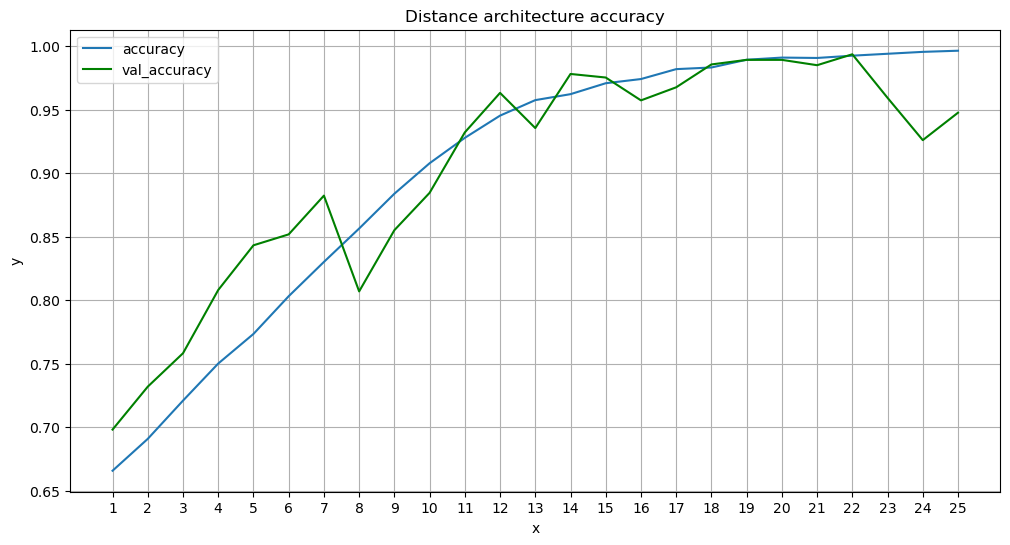

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# Przykładowe dane
x = range(1,len(dense_val_acc)+1)
y1 = dense_train_loss
y2 = dense_train_acc
y3 = dense_val_loss
y4 = dense_val_acc

# Tworzenie wykresu
plt.figure(figsize=(12, 6))

# Wykres liniowy dla y1
# plt.plot(x, y1, label='loss')

# Wykres liniowy dla y2
plt.plot(x, y2, label='accuracy')

# Wykres punktowy dla y3
# plt.scatter(x, y3, label='val_loss')

# Wykres liniowy dla y4
plt.plot(x, y4, label='val_accuracy', color='green')

# Dodawanie legendy
plt.legend()
plt.xticks(x, [str(i) for i in x]) 
# Tytuł i etykiety osi
plt.title('Distance architecture accuracy')
plt.xlabel('x')
plt.ylabel('y')
# Wyświetlenie wykresu
plt.grid(True)
plt.show()

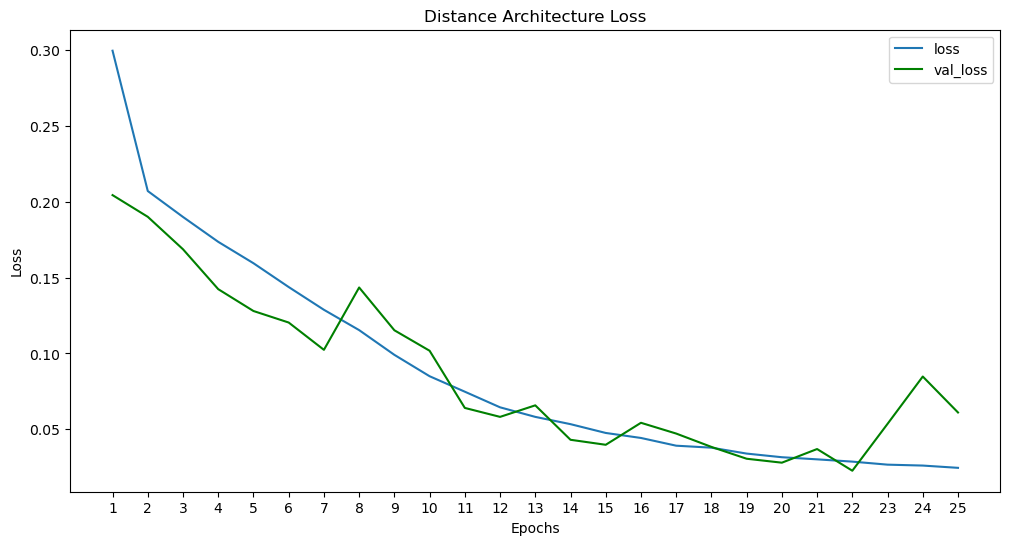

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

x = range(1,len(dense_val_acc)+1)
y1 = dense_train_loss
y3 = dense_val_loss
# y1.reverse();y2.reverse()
# Tworzenie wykresu
plt.figure(figsize=(12, 6))

# Wykres liniowy dla y1
plt.plot(x, y1, label='loss')

# Wykres punktowy dla y3
plt.plot(x, y3, label='val_loss', color='green')
# Dodawanie legendy
plt.legend()
plt.xticks(x, [str(i) for i in x]) 

# Tytuł i etykiety osi
# plt.gca().invert_yaxis()
plt.title('Distance Architecture Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [18]:
import re
#distance
dense_train_loss = []
dense_train_acc =  []
dense_val_loss =   []
dense_val_acc =    []


distance_val_acc = []
distance_val_loss = []
distance_train_loss = []
distance_train_acc = []
# Przykładowy tekst z danymi o accuracy, loss, val_accuracy i val_loss
text = """
Epoch 1/40 1805/1805 [==============================] - 424s 216ms/step - loss: 0.2996 - accuracy: 0.6657 - val_loss: 0.2044 - val_accuracy: 0.6981
Epoch 2/40 1805/1805 [==============================] - 401s 222ms/step - loss: 0.2071 - accuracy: 0.6908 - val_loss: 0.1901 - val_accuracy: 0.7319
Epoch 3/40 1805/1805 [==============================] - 408s 226ms/step - loss: 0.1900 - accuracy: 0.7209 - val_loss: 0.1687 - val_accuracy: 0.7582
Epoch 4/40 1805/1805 [==============================] - 407s 225ms/step - loss: 0.1736 - accuracy: 0.7501 - val_loss: 0.1424 - val_accuracy: 0.8080
Epoch 5/40 1805/1805 [==============================] - 405s 225ms/step - loss: 0.1595 - accuracy: 0.7734 - val_loss: 0.1280 - val_accuracy: 0.8432
Epoch 6/40 1805/1805 [==============================] - 402s 222ms/step - loss: 0.1438 - accuracy: 0.8031 - val_loss: 0.1204 - val_accuracy: 0.8518
Epoch 7/40 1805/1805 [==============================] - 399s 221ms/step - loss: 0.1288 - accuracy: 0.8301 - val_loss: 0.1024 - val_accuracy: 0.8823
Epoch 8/40 1805/1805 [==============================] - 399s 221ms/step - loss: 0.1154 - accuracy: 0.8564 - val_loss: 0.1435 - val_accuracy: 0.8069
Epoch 9/40 1805/1805 [==============================] - 402s 223ms/step - loss: 0.0991 - accuracy: 0.8838 - val_loss: 0.1153 - val_accuracy: 0.8551
Epoch 10/40 1805/1805 [==============================] - 384s 213ms/step - loss: 0.0850 - accuracy: 0.9078 - val_loss: 0.1018 - val_accuracy: 0.8845
Epoch 11/40 1805/1805 [==============================] - 390s 216ms/step - loss: 0.0748 - accuracy: 0.9278 - val_loss: 0.0641 - val_accuracy: 0.9321
Epoch 12/40 1805/1805 [==============================] - 378s 210ms/step - loss: 0.0645 - accuracy: 0.9453 - val_loss: 0.0582 - val_accuracy: 0.9632
Epoch 13/40 1805/1805 [==============================] - 378s 210ms/step - loss: 0.0582 - accuracy: 0.9575 - val_loss: 0.0658 - val_accuracy: 0.9355
Epoch 14/40 1805/1805 [==============================] - 378s 209ms/step - loss: 0.0534 - accuracy: 0.9622 - val_loss: 0.0431 - val_accuracy: 0.9781
Epoch 15/40 1805/1805 [==============================] - 381s 211ms/step - loss: 0.0476 - accuracy: 0.9708 - val_loss: 0.0398 - val_accuracy: 0.9753
Epoch 16/40 1805/1805 [==============================] - 401s 222ms/step - loss: 0.0443 - accuracy: 0.9741 - val_loss: 0.0543 - val_accuracy: 0.9573
Epoch 17/40 1805/1805 [==============================] - 397s 220ms/step - loss: 0.0392 - accuracy: 0.9819 - val_loss: 0.0472 - val_accuracy: 0.9676
Epoch 18/40 1805/1805 [==============================] - 391s 217ms/step - loss: 0.0379 - accuracy: 0.9832 - val_loss: 0.0384 - val_accuracy: 0.9856
Epoch 19/40 1805/1805 [==============================] - 380s 211ms/step - loss: 0.0340 - accuracy: 0.9893 - val_loss: 0.0306 - val_accuracy: 0.9892
Epoch 20/40 1805/1805 [==============================] - 378s 209ms/step - loss: 0.0316 - accuracy: 0.9910 - val_loss: 0.0280 - val_accuracy: 0.9892
Epoch 21/40 1805/1805 [==============================] - 389s 216ms/step - loss: 0.0302 - accuracy: 0.9907 - val_loss: 0.0370 - val_accuracy: 0.9850
Epoch 22/40 1805/1805 [==============================] - 398s 220ms/step - loss: 0.0287 - accuracy: 0.9925 - val_loss: 0.0227 - val_accuracy: 0.9936
Epoch 23/40 1805/1805 [==============================] - 387s 214ms/step - loss: 0.0267 - accuracy: 0.9940 - val_loss: 0.0536 - val_accuracy: 0.9593
Epoch 24/40 1805/1805 [==============================] - 384s 213ms/step - loss: 0.0261 - accuracy: 0.9955 - val_loss: 0.0848 - val_accuracy: 0.9260
Epoch 25/40 1805/1805 [==============================] - 377s 209ms/step - loss: 0.0246 - accuracy: 0.9964 - val_loss: 0.0611 - val_accuracy: 0.9476
"""

# Wyrażenia regularne do wyodrębnienia wartości
pattern = r"Epoch \d+/\d+ .* loss: ([\d.]+) - accuracy: ([\d.]+) .* val_loss: ([\d.]+) - val_accuracy: ([\d.]+)"

# Wyszukaj dopasowania w tekście
matches = re.findall(pattern, text)
print(matches)
# Przetwórz wyniki
for match in matches:
    loss, accuracy, val_loss, val_accuracy = match
    dense_train_loss.append(float(loss))
    dense_train_acc.append(float(accuracy))
    dense_val_loss.append(float(val_loss))
    dense_val_acc.append(float(val_accuracy))
    
print(dense_train_loss)

[('0.2996', '0.6657', '0.2044', '0.6981'), ('0.2071', '0.6908', '0.1901', '0.7319'), ('0.1900', '0.7209', '0.1687', '0.7582'), ('0.1736', '0.7501', '0.1424', '0.8080'), ('0.1595', '0.7734', '0.1280', '0.8432'), ('0.1438', '0.8031', '0.1204', '0.8518'), ('0.1288', '0.8301', '0.1024', '0.8823'), ('0.1154', '0.8564', '0.1435', '0.8069'), ('0.0991', '0.8838', '0.1153', '0.8551'), ('0.0850', '0.9078', '0.1018', '0.8845'), ('0.0748', '0.9278', '0.0641', '0.9321'), ('0.0645', '0.9453', '0.0582', '0.9632'), ('0.0582', '0.9575', '0.0658', '0.9355'), ('0.0534', '0.9622', '0.0431', '0.9781'), ('0.0476', '0.9708', '0.0398', '0.9753'), ('0.0443', '0.9741', '0.0543', '0.9573'), ('0.0392', '0.9819', '0.0472', '0.9676'), ('0.0379', '0.9832', '0.0384', '0.9856'), ('0.0340', '0.9893', '0.0306', '0.9892'), ('0.0316', '0.9910', '0.0280', '0.9892'), ('0.0302', '0.9907', '0.0370', '0.9850'), ('0.0287', '0.9925', '0.0227', '0.9936'), ('0.0267', '0.9940', '0.0536', '0.9593'), ('0.0261', '0.9955', '0.0848', '0